In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import random
import seaborn as sns
import joblib

In [2]:
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
!gdown 1i3kqlK9XovB5ecfRAsvtHV3cQUnso7K_

Downloading...
From (original): https://drive.google.com/uc?id=1i3kqlK9XovB5ecfRAsvtHV3cQUnso7K_
From (redirected): https://drive.google.com/uc?id=1i3kqlK9XovB5ecfRAsvtHV3cQUnso7K_&confirm=t&uuid=31bceb79-a781-41db-8dfc-b871142f476d
To: /content/drone_bird.zip
100% 42.0M/42.0M [00:02<00:00, 17.2MB/s]


In [4]:
!unzip /content/drone_bird.zip

Archive:  /content/drone_bird.zip
  inflating: drone_or_bird/birds/031e09fe-47cd-4523-b8c9-3591b7bd1f3b.jpg  
  inflating: drone_or_bird/birds/050a45d2-e917-442f-9979-53f9017a8538.jpg  
  inflating: drone_or_bird/birds/0628debe-4429-4d78-b4ad-30f5e951841c.jpg  
  inflating: drone_or_bird/birds/062a9627-2453-443c-99d0-549fe98704b0.jpg  
  inflating: drone_or_bird/birds/0659ed65-704f-450e-84f6-a50354b13243.jpg  
  inflating: drone_or_bird/birds/07da8bc1-df13-4b00-8000-f68825234016.jpeg  
  inflating: drone_or_bird/birds/08863cbd-4a84-46ae-a5f5-920579de1b6f.png  
  inflating: drone_or_bird/birds/0a5b4074-52c7-42d5-8b5e-54b4f93fc129.jpg  
  inflating: drone_or_bird/birds/0adf7f21-6068-47f0-84f0-c464f855a85d.jpg  
  inflating: drone_or_bird/birds/0b4a4fad-0a27-441d-b312-cefde471a722.jpg  
  inflating: drone_or_bird/birds/0bf9f08a-2693-42e6-ab35-9f08f97e4603.jpg  
  inflating: drone_or_bird/birds/0c251caa-9ed5-4f35-bdaa-a632584c8be7.jpg  
  inflating: drone_or_bird/birds/0e4aaa7a-92ab-4d96-9

# Preprocessing

In [5]:
def augment_image(img):
    rows, cols, _ = img.shape

    angle = random.uniform(-10, 10)
    M = cv.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    img = cv.warpAffine(img, M, (cols, rows))

    if random.choice([True, False]):
        img = cv.flip(img, 1)

    scale = random.uniform(0.9, 1.1)
    img = cv.resize(img, None, fx=scale, fy=scale, interpolation=cv.INTER_LINEAR)

    return img

In [6]:
def read_image(img_path):
  if img_path.endswith(".gif"):
    cap = cv.VideoCapture(img_path)
    ret, frame = cap.read()
    img = frame
  else:
    img = cv.imread(img_path, cv.COLOR_BGR2RGB)
  return img

In [27]:
def preprocess_image(img, target_size=(128, 72), hog_=True):
  img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  img = cv.resize(img, target_size, interpolation=cv.INTER_AREA)

  img_blur = cv.bilateralFilter(img,7,75,100)

  laplacian = cv.Laplacian(img_blur, cv.CV_64F, ksize=3)
  img_laplacian = cv.convertScaleAbs(img_blur - laplacian)

  image_data = img_laplacian

  if hog_:
    hog_features, hog_image = hog(img_laplacian, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2),
                                block_norm='L2-Hys', visualize=True, transform_sqrt=True)
    image_data = hog_features

  return image_data

In [11]:
dataset_dir = '/content/drone_or_bird'

data = []
labels = []


for class_name in os.listdir(dataset_dir):
  class_dir = os.path.join(dataset_dir, class_name)
  for img_name in os.listdir(class_dir):
    img_path = os.path.join(class_dir, img_name)
    img_ = read_image(img_path)
    img = preprocess_image(img_)
    data.append(img.flatten())
    labels.append(class_name)
    for _ in range(5):
      img_aug = augment_image(img_)
      hog_features_aug = preprocess_image(img_aug)
      data.append(hog_features_aug.flatten())
      labels.append(class_name)

data = np.asarray(data)
labels = np.asarray(labels)

In [ ]:
class_folders = os.listdir(dataset_dir)
class_paths = [os.path.join(dataset_dir, path) for path in class_folders]
class_paths

['/content/drone_or_bird/drones', '/content/drone_or_bird/birds']

# Sample Data

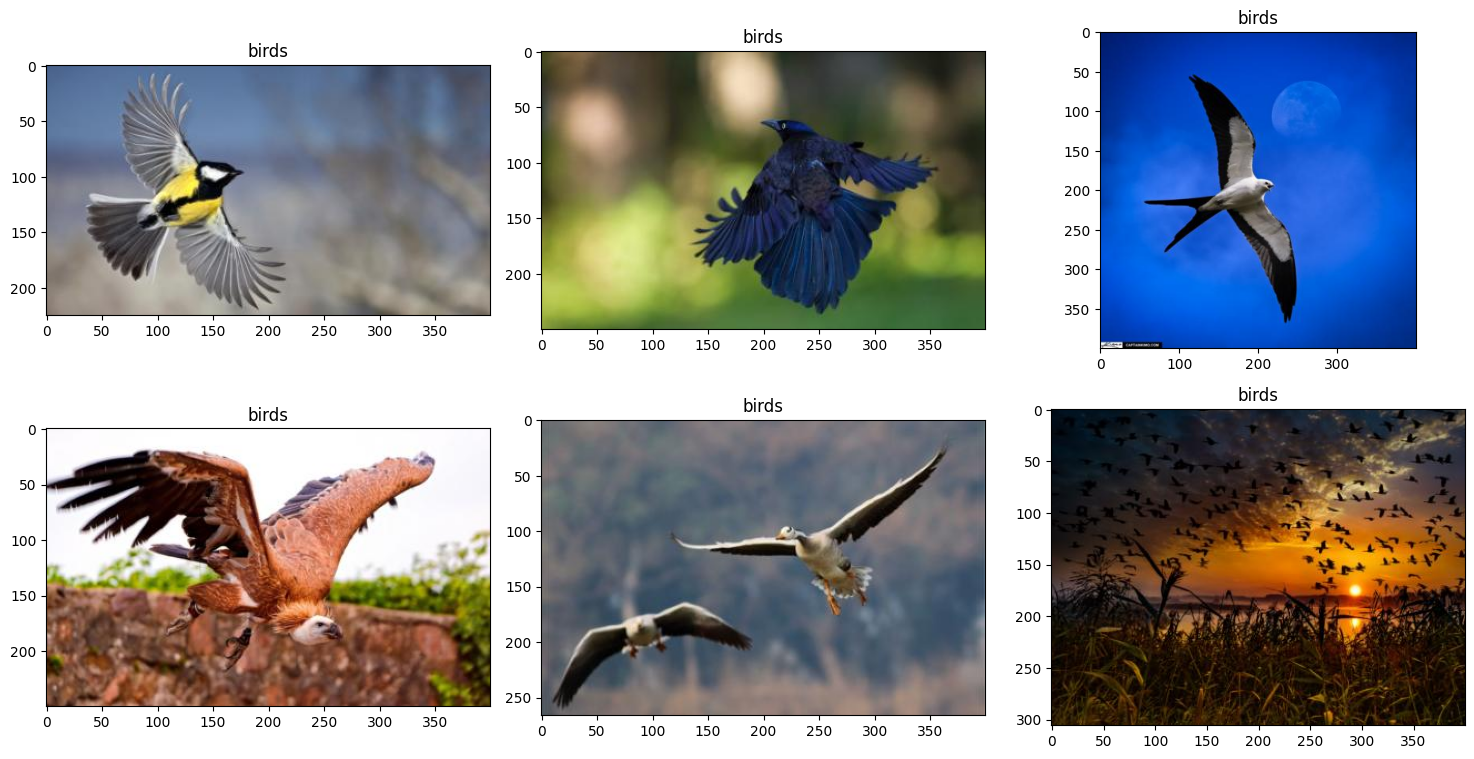

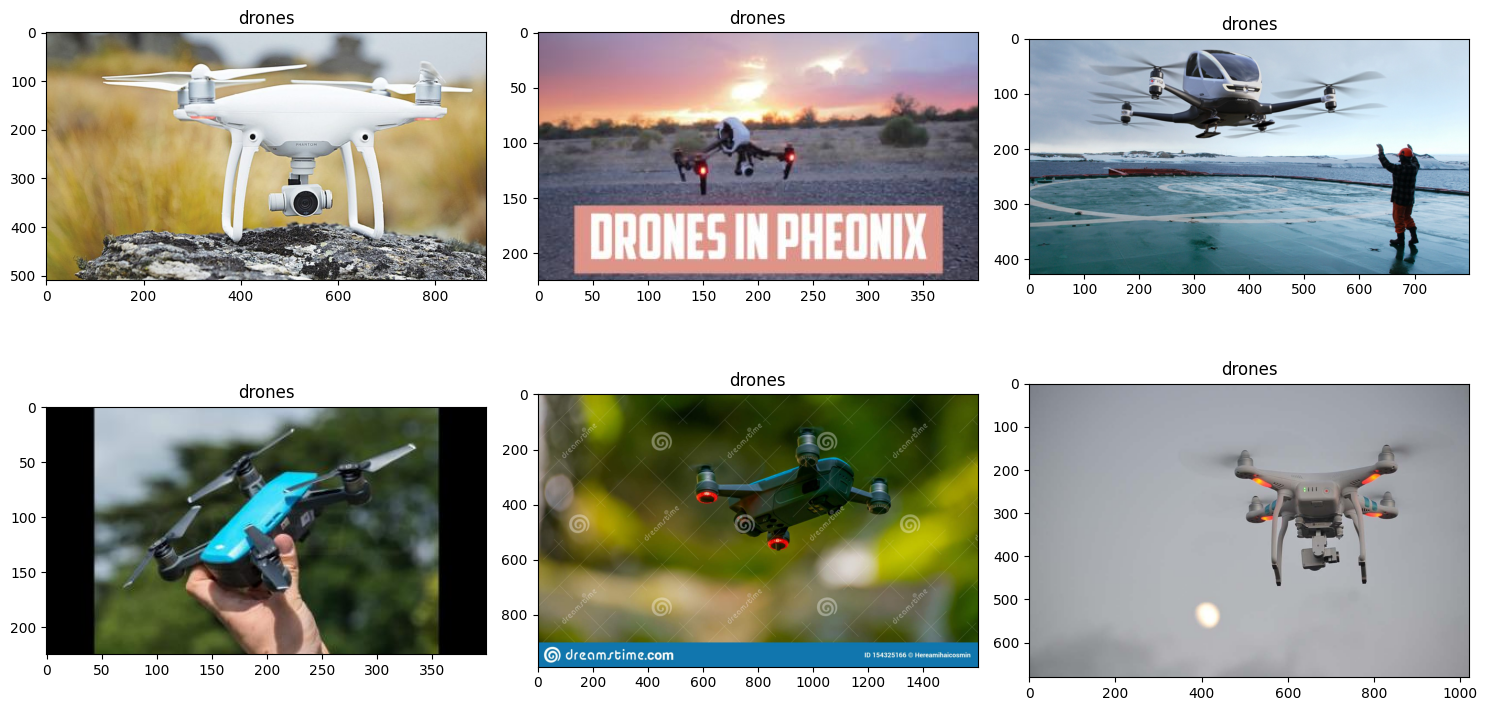

In [ ]:
def plot_imgs(item_dir, title=" ", num_imgs=4, cmap='viridis'):
    all_item_dirs = os.listdir(item_dir)
    item_files = np.random.permutation([os.path.join(item_dir, file) for file in all_item_dirs])[:num_imgs]

    plt.figure(figsize=(15, 15))
    for idx, img_path in enumerate(item_files):
        plt.subplot(4, 3, idx+1)
        img = plt.imread(img_path, 0)
        plt.title(title)
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()

for path in class_paths:
    head, tail = os.path.split(path)
    plot_imgs(path, tail, 6)

['/content/drone_or_bird/birds/cb5aa262-b03a-4e07-82a7-ea7bfcdb84f5.jpg', '/content/drone_or_bird/birds/235f60db-4df4-4203-b538-3018faf34c4f.jpg', '/content/drone_or_bird/drones/0ff3da67-09bd-41e0-87d1-2d665ea00208.png', '/content/drone_or_bird/drones/0e3dcfd8-9162-43e3-aeeb-ef7b03ddf304.jpg']


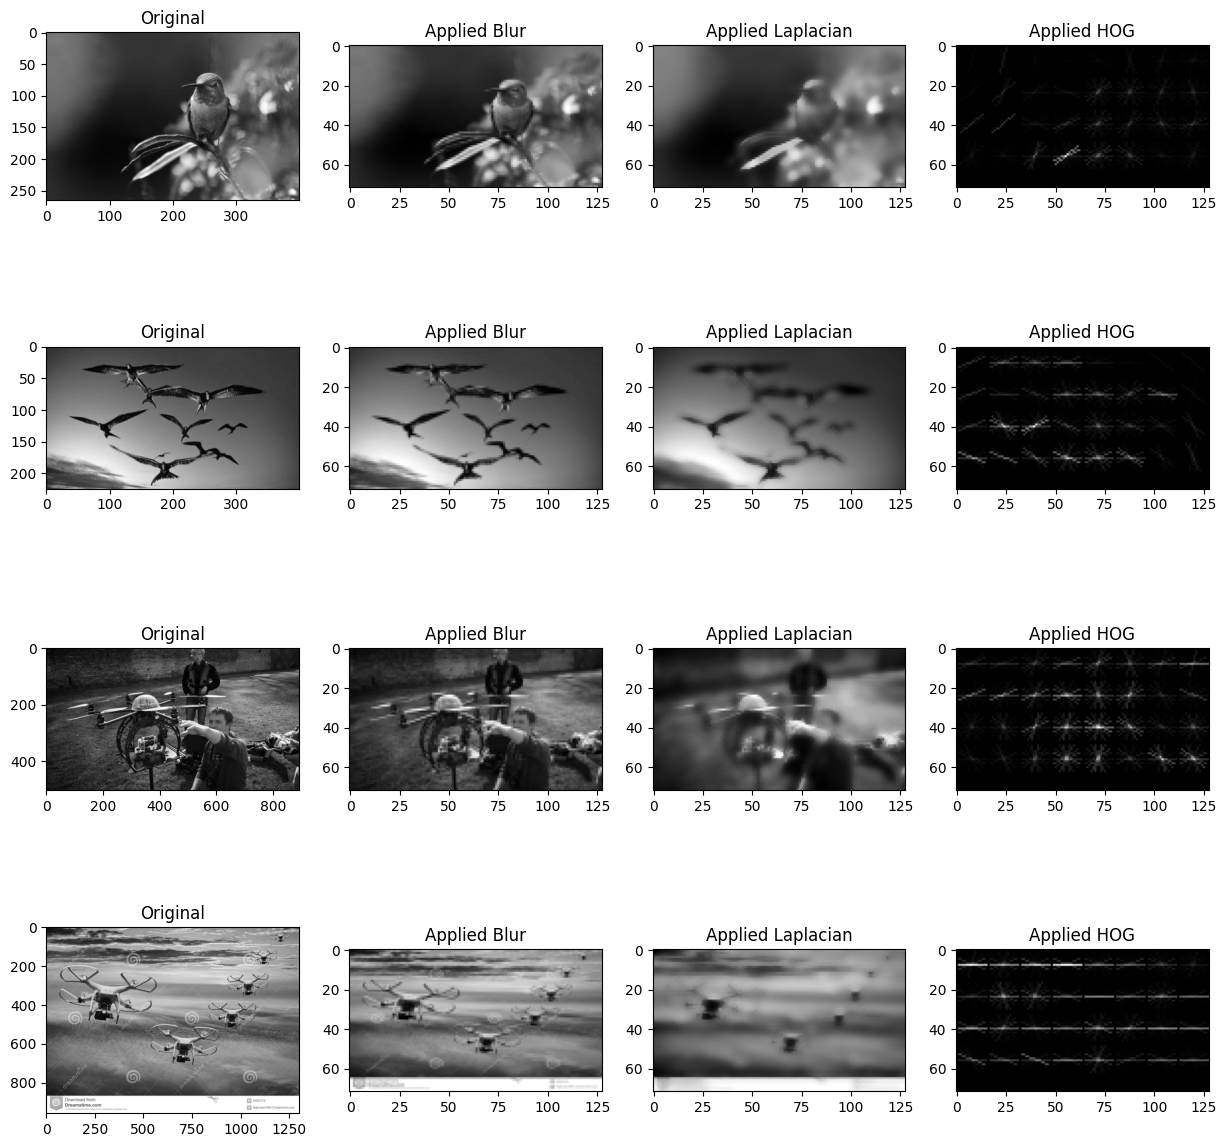

In [ ]:
from skimage.filters import *

plots = [
    os.path.join(dir_, random.choice(os.listdir(dir_)))
    for dir_ in [class_paths[0], class_paths[1]] for _ in range(2)
]
print(plots)


plt.figure(figsize=(15, 15))
for i, plot in enumerate(plots):

    img_ori = cv.imread(plot)
    img_ori = cv.cvtColor(img_ori, cv.COLOR_BGR2GRAY)
    img = cv.resize(img_ori, (128, 72), interpolation=cv.INTER_AREA)

    img_blur = cv.bilateralFilter(img,7,75,100)

    laplacian = cv.Laplacian(img_blur, cv.CV_64F, ksize=3)
    img_laplacian = cv.convertScaleAbs(img_blur - laplacian)

    hog_features, hog_image = hog(img_blur, orientations=9, pixels_per_cell=(16, 16), cells_per_block=(2, 2),
                                  block_norm='L2-Hys', visualize=True, transform_sqrt=True)

    plt.subplot(4,4, 1 + i * 4)
    plt.imshow(img, cmap="gray")
    plt.title("Original")

    plt.subplot(4,4, 1 + i * 4 + 1)
    plt.imshow(img_blur, cmap="gray")
    plt.title("Applied Blur")

    plt.subplot(4,4, 1 + i * 4 + 2)
    plt.imshow(img_laplacian, cmap="gray")
    plt.title("Applied Laplacian")

    plt.subplot(4,4, 1 + i * 4 + 3)
    plt.imshow(hog_image, cmap="gray")
    plt.title("Applied HOG")

# Classification

In [12]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels)

In [15]:
classifiers = [
    SVC(),
    KNeighborsClassifier(),
    LogisticRegression(max_iter=1000)
]

In [16]:
parameters = [
    {'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 'C': [0.01, 0.1, 1, 10, 100],
     'gamma': [0.001, 0.01, 0.1, 1, 10], 'degree': [2, 3, 4, 5]},
    {'n_neighbors': range(1, 20), 'algorithm': ['auto', 'ball_tree', 'kd_tree'],
     'metric': ['euclidean', 'manhattan', 'minkowski']},
    {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs', 'sag'],
     'penalty': ['l1', 'l2']},
]

In [17]:
clf = classifiers[0]
clf

SVC()

In [18]:
param = parameters[0]
param

{'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
 'C': [0.01, 0.1, 1, 10, 100],
 'gamma': [0.001, 0.01, 0.1, 1, 10],
 'degree': [2, 3, 4, 5]}

In [19]:
kfold = KFold(n_splits=5, shuffle=True)

In [20]:
grid_search = GridSearchCV(estimator=clf, param_grid=param, cv=kfold)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'degree': [2, 3, 4, 5],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'rbf', 'poly', 'sigmoid']})

In [21]:
grid_search.best_params_

{'C': 0.01, 'degree': 5, 'gamma': 1, 'kernel': 'poly'}

In [22]:
best_model = grid_search.best_estimator_
best_model

SVC(C=0.01, degree=5, gamma=1, kernel='poly')

In [23]:
best_model.fit(x_train, y_train)

SVC(C=0.01, degree=5, gamma=1, kernel='poly')

# OLD - Multi Models

In [ ]:
models =[]

In [ ]:
for i, (clf, param) in enumerate(zip(classifiers, parameters)):
    gs = GridSearchCV(estimator=clf, param_grid=param, cv=kfold)
    gs.fit(x_train, y_train)
    models.append(gs)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

In [ ]:
print(*[model.best_params_ for model in models], sep="\n")

{'C': 0.01, 'degree': 3, 'gamma': 0.001, 'kernel': 'linear'}
{'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 1}
{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


In [ ]:
model = SVC(C=grid_search.best_params_['C'], gamma=grid_search.best_params_['gamma'])
model.fit(x_train, y_train)

SVC(C=0.01, gamma=0.001)

In [ ]:
svc_model=SVC(C=models[0].best_params_['C'], gamma=models[0].best_params_['gamma'])
svc_model.fit(x_train, y_train)

knn_model=KNeighborsClassifier(n_neighbors=models[1].best_params_['n_neighbors'])
knn_model.fit(x_train, y_train)

lr_model=LogisticRegression(C=models[2].best_params_['C'])
lr_model.fit(x_train, y_train)

LogisticRegression(C=10)

#Evaluation

In [24]:
y_prediction = best_model.predict(x_test)

score = accuracy_score(y_test, y_prediction)
cm = confusion_matrix(y_test, y_prediction)

print('{}% of samples were correctly classified'.format(str(score * 100)))

94.44444444444444% of samples were correctly classified


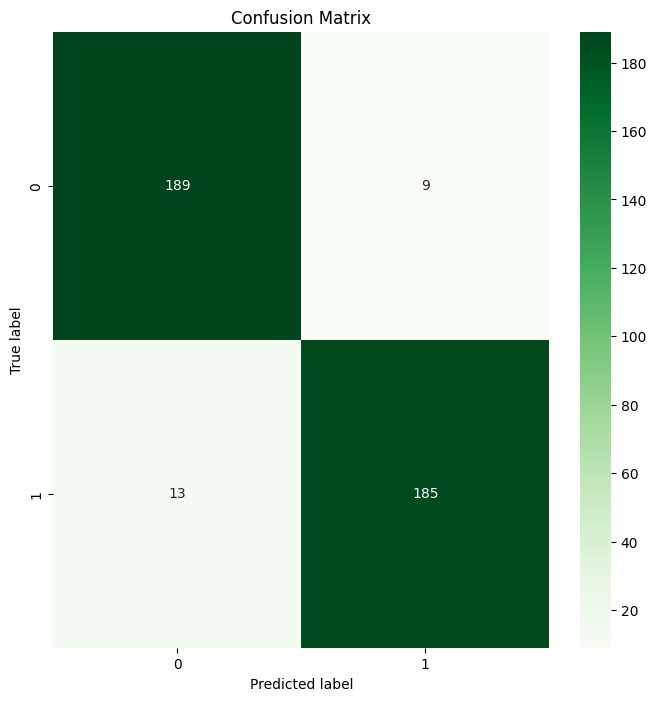

In [25]:
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [26]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

       birds       0.94      0.95      0.95       198
      drones       0.95      0.93      0.94       198

    accuracy                           0.94       396
   macro avg       0.94      0.94      0.94       396
weighted avg       0.94      0.94      0.94       396



# OLD - Multi Eval

In [ ]:
svc_y_pred = svc_model.predict(x_test)

svc_score = accuracy_score(y_test, svc_y_pred)
svc_cm = confusion_matrix(y_test, svc_y_pred)
print('{}% of samples were correctly classified'.format(str(svc_score * 100)))

knn_y_pred = knn_model.predict(x_test)

knn_score = accuracy_score(y_test, knn_y_pred)
knn_cm = confusion_matrix(y_test, knn_y_pred)
print('{}% of samples were correctly classified'.format(str(knn_score * 100)))

lr_y_pred = lr_model.predict(x_test)

lr_score = accuracy_score(y_test, lr_y_pred)
lr_cm = confusion_matrix(y_test, lr_y_pred)
print('{}% of samples were correctly classified'.format(str(lr_score * 100)))

69.6969696969697% of samples were correctly classified
74.24242424242425% of samples were correctly classified
62.121212121212125% of samples were correctly classified


<ipython-input-27-95303b3ef380>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,1)


<Figure size 640x480 with 0 Axes>

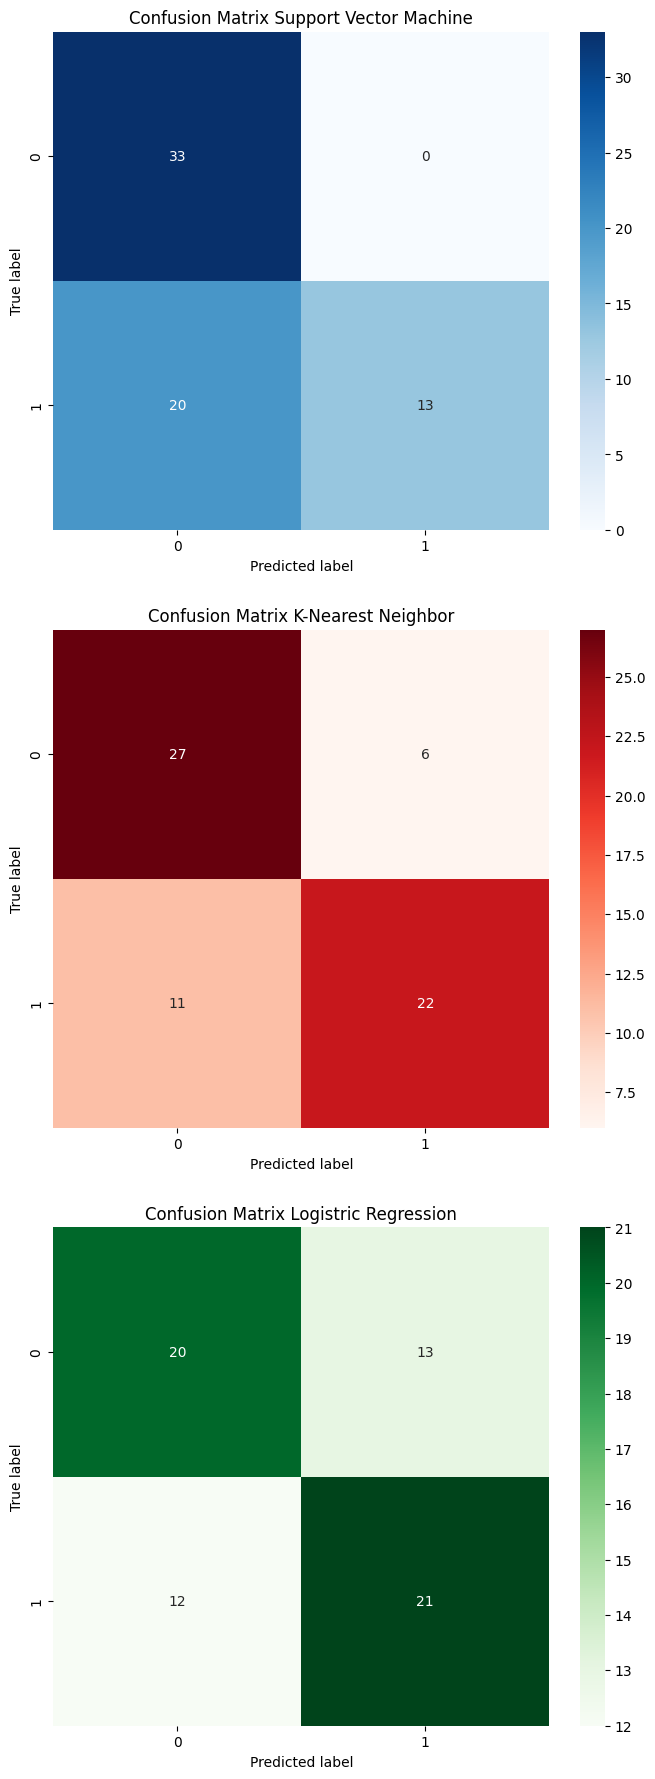

In [ ]:
plt.figure()
plt.subplots(figsize=(8, 22))
plt.subplot(3,1,1)
sns.heatmap(svc_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Support Vector Machine')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(3,1,2)
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Reds')
plt.title('Confusion Matrix K-Nearest Neighbor')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.subplot(3,1,3)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix Logistric Regression')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print("\t\t\tSVM Report")
print(classification_report(y_test, svc_y_pred))
print("~\t~\t~\t~\t~\t~\t~\t~\t\n")

print("\t\t\tKNN Report")
print(classification_report(y_test, knn_y_pred))
print("~\t~\t~\t~\t~\t~\t~\t~\t\n")

print("\t\t\tLR Report")
print(classification_report(y_test, lr_y_pred))

			SVM Report
              precision    recall  f1-score   support

       birds       0.62      1.00      0.77        33
      drones       1.00      0.39      0.57        33

    accuracy                           0.70        66
   macro avg       0.81      0.70      0.67        66
weighted avg       0.81      0.70      0.67        66

~	~	~	~	~	~	~	~	

			KNN Report
              precision    recall  f1-score   support

       birds       0.71      0.82      0.76        33
      drones       0.79      0.67      0.72        33

    accuracy                           0.74        66
   macro avg       0.75      0.74      0.74        66
weighted avg       0.75      0.74      0.74        66

~	~	~	~	~	~	~	~	

			LR Report
              precision    recall  f1-score   support

       birds       0.62      0.61      0.62        33
      drones       0.62      0.64      0.63        33

    accuracy                           0.62        66
   macro avg       0.62      0.62      0.62        

[Save Model](https://neptune.ai/blog/saving-trained-model-in-python)

[CV Eval](https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/)

# Save & Load Model

In [ ]:
model_filename = 'drone_bird_modelv1.sav'
joblib.dump(model, model_filename)

['drone_bird_modelv1.sav']

In [ ]:
model_hog = 'drone_bird_modelv2.sav'
joblib.dump(best_model, model_hog)

In [ ]:
model_hog_prob = 'drone_bird_modelv3.sav'
joblib.dump(best_model, model_hog_prob)

In [ ]:
joblib.dump(svc_model, 'drone_bird_model_svm.sav')
joblib.dump(knn_model, 'drone_bird_model_knn.sav')
joblib.dump(lr_model, 'drone_bird_model_lr.sav')

['drone_bird_model_lr.sav']

In [ ]:
loaded_model = joblib.load(model_filename)

y_predict = model.predict(x_test)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       birds       0.62      1.00      0.77        33
      drones       1.00      0.39      0.57        33

    accuracy                           0.70        66
   macro avg       0.81      0.70      0.67        66
weighted avg       0.81      0.70      0.67        66



In [ ]:
model_hog = 'drone_bird_modelv2.sav'
loaded_model = joblib.load(model_hog)

rq = read_image('bird_request.jpg')
# print(rq)
rq_data = preprocess_image(rq)
# print(rq_data)
rq_array = np.asarray(rq_data)
print(rq_array)
print(type(rq_array))

y_pr = loaded_model.predict(rq_array.reshape(1, -1) )

print(y_pr)

[0.21291584 0.13857613 0.14966757 0.20460701 0.21291584 0.1561776
 0.18955352 0.18620948 0.07892743 0.21291584 0.09992931 0.20517678
 0.15102144 0.17777693 0.21291584 0.21291584 0.15098658 0.14256467
 0.21291584 0.08752399 0.11764743 0.1108171  0.18151743 0.12520341
 0.15799924 0.14019507 0.11456363 0.2048339  0.15847328 0.16190037
 0.12322368 0.18608278 0.14176216 0.21291584 0.15391086 0.14604674
 0.13879005 0.05861228 0.12034385 0.08857972 0.10427281 0.13744875
 0.1520364  0.08855927 0.0836195  0.12772688 0.13695637 0.06090207
 0.18016646 0.25017484 0.25017484 0.20079395 0.11073292 0.05799569
 0.12014274 0.0929505  0.09496062 0.07227529 0.10914451 0.0831488
 0.17438968 0.09027447 0.08566187 0.25017484 0.25017484 0.25017484
 0.1793291  0.25017484 0.25017484 0.25017484 0.25017484 0.25017484
 0.03061192 0.03282392 0.01459621 0.04317995 0.07379149 0.072333
 0.04812368 0.02653903 0.01389965 0.0314389  0.04909039 0.14834595
 0.22075605 0.27745743 0.18484461 0.04412785 0.06596873 0.04307673